In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset from CSV (update path if needed)
df = pd.read_csv('Telco_Customer_Churn.csv')

# Basic inspection
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
print(df.head())
print("\nColumn Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())



Dataset Shape: (7043, 21)

First 5 Rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Streami

In [3]:
# Quick stats
print("\nBasic Statistics:")
print(df.describe())

# Check churn distribution (target variable)
print("\nChurn Distribution:")
print(df['Churn'].value_counts(normalize=True) * 100)


Basic Statistics:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

Churn Distribution:
No     73.463013
Yes    26.536987
Name: Churn, dtype: float64


#### Preprocessing 

In [5]:
# Handle missing values in TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  # Convert to numeric, invalid to NaN
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)  # Fill NaN with median

In [6]:
# Drop customerID (not useful for modeling)
df = df.drop('customerID', axis=1)


In [7]:
# Encode categorical variables
le = LabelEncoder()
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    if col == 'Churn':
        df[col] = le.fit_transform(df[col])  # Encode target (Churn: Yes=1, No=0)
    else:
        df = pd.get_dummies(df, columns=[col], drop_first=True)  # One-hot encode other categoricals

In [8]:
# Define features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

In [9]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Verify shapes
print("Training Features Shape:", X_train.shape)
print("Test Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Test Target Shape:", y_test.shape)


Training Features Shape: (5634, 30)
Test Features Shape: (1409, 30)
Training Target Shape: (5634,)
Test Target Shape: (1409,)


In [11]:
# Check a sample of preprocessed features
print("\nSample of Preprocessed Features (first 5 rows):")
print(X_train.head())


Sample of Preprocessed Features (first 5 rows):
      SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Male  \
2142              0      21           64.85      1336.800            0   
1623              0      54           97.20      5129.450            0   
6074              0       1           23.45        23.450            1   
1362              0       4           70.20       237.950            1   
6754              0       0           61.90      1397.475            1   

      Partner_Yes  Dependents_Yes  PhoneService_Yes  \
2142            0               1                 1   
1623            0               0                 1   
6074            1               0                 0   
1362            0               0                 1   
6754            0               1                 1   

      MultipleLines_No phone service  MultipleLines_Yes  ...  \
2142                               0                  0  ...   
1623                               0           

### Training, Evaluation, and Visualizing the Model

In [14]:
# Train logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [15]:
# Predict on test set
y_pred = model.predict(X_test)

In [16]:
# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

Accuracy: 0.8183108587650816

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.86      0.90      0.88      1036
       Churn       0.68      0.58      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409



In [17]:
# Visualize feature importance
importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.coef_[0]})
importance = importance.sort_values(by='Importance', ascending=False)

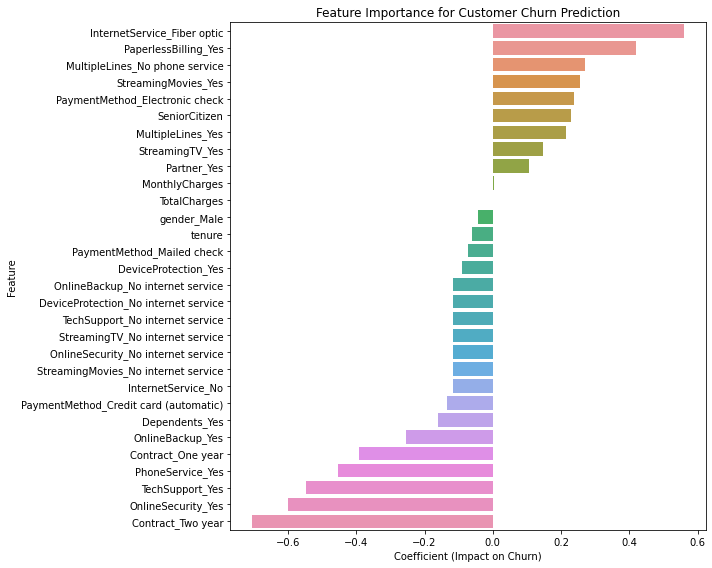

<Figure size 432x288 with 0 Axes>

In [21]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('Feature Importance for Customer Churn Prediction')
plt.xlabel('Coefficient (Impact on Churn)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')


In [20]:
# Business Intelligence Insights
churn_rate = y.mean() * 100
print(f"\nBusiness Insights:")
print(f"Churn Rate: {churn_rate:.2f}%")
print("Key Drivers of Churn (from feature importance):")
print("- Positive coefficients (e.g., high MonthlyCharges, Fiber optic): Increase churn likelihood.")
print("- Negative coefficients (e.g., long tenure, two-year contracts): Reduce churn likelihood.")
print("Actionable Strategy: Offer discounts to customers with high MonthlyCharges or Fiber optic plans to reduce churn.")
print("Potential Impact: Reducing churn by 10% could save $X annually (assuming avg. monthly charge of $70).")



Business Insights:
Churn Rate: 26.54%
Key Drivers of Churn (from feature importance):
- Positive coefficients (e.g., high MonthlyCharges, Fiber optic): Increase churn likelihood.
- Negative coefficients (e.g., long tenure, two-year contracts): Reduce churn likelihood.
Actionable Strategy: Offer discounts to customers with high MonthlyCharges or Fiber optic plans to reduce churn.
Potential Impact: Reducing churn by 10% could save $X annually (assuming avg. monthly charge of $70).
